In [12]:
import pandas as pd
import yaml
import sys
sys.path.append('../')
import seaborn as sns
import torchvision.models as models
from matplotlib import pyplot as plt
from utils.data_utils import preprocess_and_normalize_energy_data
from utils.architecture_utils import get_modules_from_architecture
from run_estimation import compute_energy_estimate
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2
pd.set_option("display.precision", 5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Customn Definitions

In [13]:
# dictionary of architecture names and their PyTorch instances
architectures_dict = {
    'alexnet': models.alexnet(weights=None),
    'vgg13': models.vgg13(weights=None),
    'vgg11': models.vgg11(weights=None),
    'vgg16': models.vgg16(weights=None),
    'resnet18': models.resnet18(weights=None),
    'resnet34': models.resnet34(weights=None),
    'resnet50': models.resnet50(weights=None)
}

# Data Preparation
## Load Data & Normalize

In [14]:
# load
df_unnormalized = pd.read_csv('../data/architectures-energies-2-parsed.csv')
# normalize
df = preprocess_and_normalize_energy_data(df_unnormalized,['module','batch_size','architecture','layer_idx'], aggregate=True, verbose=True, num_repeat_config=3, slurm_log_info=('../data/slurm-7520393.out','architectures'))
print("Measured models:", df.architecture.unique())
df.head(n=15)

Dropped observations with the following indices: [68, 199, 259, 430, 450, 642, 661, 824, 882, 1109, 1200, 1387, 1561, 1571, 1747, 1930, 1999, 2116]
Shape before aggregation: (2103, 36), after aggregation: (707, 26) (non numeric columns removed)
Final shape of data set: (707, 26)
Measured models: ['alexnet' 'vgg11' 'vgg13']


,module,batch_size,architecture,layer_idx,Unnamed: 0,duration,emissions,emissions_rate,cpu_power,gpu_power,...,cloud_provider,cloud_region,cpu_count,gpu_count,longitude,latitude,ram_total_size,rep_no,macs,forward_passes
0,AlexNet,66,alexnet,0,1.0,30.21035,0.00097,0.03206,75.65588,30.46033,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,4.72271e+10,24.00000
1,Conv2d,66,alexnet,1,4.0,30.12263,0.00099,0.03292,75.32138,30.39767,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,4.65105e+09,207.66667
2,ReLU,66,alexnet,2,7.0,30.03493,0.00098,0.03264,79.94837,30.76100,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.27776e+07,8639.33333
3,MaxPool2d,66,alexnet,3,10.0,30.06525,0.00097,0.03214,75.56390,30.39200,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.38568e+07,417.00000
4,Conv2d,66,alexnet,4,13.0,30.18550,0.00102,0.03364,76.95592,30.09167,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,1.47899e+10,92.00000
5,ReLU,66,alexnet,5,16.0,30.03584,0.00098,0.03251,79.98659,30.10500,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,9.23789e+06,13123.66667
6,MaxPool2d,66,alexnet,6,19.0,30.06079,0.00096,0.03208,75.46994,30.10833,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,9.63706e+06,592.00000
7,Conv2d,66,alexnet,7,22.0,30.08910,0.00097,0.03213,76.20175,30.31800,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,7.40554e+09,195.33333
8,ReLU,66,alexnet,8,25.0,30.03441,0.00097,0.03236,78.85640,30.10700,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,4.28314e+06,38050.33333
9,Conv2d,66,alexnet,9,28.0,30.11422,0.00097,0.03214,76.52233,30.04533,...,NaN,NaN,2.0,1.0,9.491,51.2993,770.0,2.0,9.87120e+09,147.00000


## Ensuring that module-wise observations are complete for every architecture and batch-size

In [15]:
for a in df.architecture.unique():
    sub = df.loc[df.architecture == a]
    num_modules_a = len(get_modules_from_architecture(architectures_dict[a]))
    for b in sub.batch_size.unique():
        sub_b = sub.loc[sub.batch_size == b]
        if num_modules_a+1 - len(sub_b) != 0:
            print(f"removing all observations from {a} with batch_size {b}")
            df = df.drop(index=sub_b.index)
print("Final data-shape: ", df.shape)

removing all observations from vgg13 with batch_size 143
Final data-shape:  (690, 26)


## Remove bad measurements with high devations

In [16]:
# compute % contribution
architecture_wise_deviations = pd.DataFrame(columns=['architecture', 'batch_size', 'percent_deviation', 'total_agg_energy','measured_energy'])
for a in df.architecture.unique():
    # subset data by architecture
    sub = df.loc[df.architecture == a]
    for b in sub.batch_size.unique():
        # subset data by batch_size
        sub_b = sub.loc[sub.batch_size == b]
        # get energy from complete architecture run
        total_measured_energy = sub_b.loc[sub_b.layer_idx == 0].cpu_energy.item()
        # subset only data from individual modules of architecture
        sub_b_modules = sub_b.loc[sub_b.layer_idx != 0]
        # compute empirical total energy from complete architecture run by summing up modules
        total_agg_energy = sum(sub_b_modules.groupby(['architecture', 'batch_size', 'module'])['cpu_energy'].sum().reset_index().cpu_energy)
        new_row = {'architecture':a, 'batch_size':b, 'percent_deviation':(total_agg_energy - total_measured_energy) / total_agg_energy, 'total_agg_energy':total_agg_energy,'measured_energy':total_measured_energy}
        architecture_wise_deviations = pd.concat([architecture_wise_deviations, pd.DataFrame(new_row,index=[0])], ignore_index=True)
# print avg energies; compare energy when running the full architecture vs summing the energy over the individual modules
agg = architecture_wise_deviations.groupby(['architecture']).mean()
agg.columns = [f"mean_{col_name}" for col_name in agg.columns]
agg

,mean_percent_deviation,mean_total_agg_energy,mean_measured_energy
architecture,,,
alexnet,-0.00023,0.00005,0.00005
vgg11,0.01349,0.00055,0.00054
vgg13,0.00718,0.00094,0.00094


In [17]:
# check for deviations that are too big
blacklist = []
data = df.copy()
for idx, row in architecture_wise_deviations.iterrows():
    if abs(row.percent_deviation) > 0.9:
        blacklist.append({'architecture': row.architecture, 'batch_size': row.batch_size})
if len(blacklist) != 0:
    print("WARNING: measurements with large deviations (>10%) detected. Corresponding observations will be removed!")
    print("Number of blacklisted configurations: ", len(blacklist))
    # remove measurements where the deviations are too big
    data_shape = data.shape
    for config in blacklist:
        data = data.loc[~(data[list(config)] == pd.Series(config)).all(axis=1)]
    print(f"A total of {data_shape[0]-data.shape[0]} rows have been removed.")
else:
    print("No bad measurements found!")

No bad measurements found!


# Predictions
## Load configuration

In [18]:
# load config
with open('../model_fitting_and_estimation_config.yaml', "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## Compute full architecture and channel-wise predictions

In [20]:
full_architecture_preds = pd.DataFrame(columns=["y", "y_hat", "batch_size", "architecture"])
channel_wise_preds = pd.DataFrame(columns=["y", "y_hat", "batch_size", "architecture", "module", "layer_idx", "sanity"])
data = df

for a_name, architecture in architectures_dict.items():
    # get data for the model
    data_a = data.loc[data['architecture'] == a_name].copy()
    data_a.reset_index(drop=True)

    # compute the predictions for the entire model
    # for all batch-sizes that were sampled
    for batch_size in data_a.batch_size.unique():
        # parse model structure and return list of channels
        # TODO: fuck why do I need to pass batch_size so early, that's dumb really dumb
        total_predicted_energy, channel_wise_energies = compute_energy_estimate(architecture=architecture,
                                                                                batch_size=batch_size,
                                                                                config=config["model_configurations"])
        # sub-select corresponding to batch_size
        data_a_batch_size = data_a.loc[data_a.batch_size == batch_size]
        # sub-select the measurement that corresponds to the entire row
        a_measurement = data_a_batch_size.loc[data_a_batch_size.layer_idx == 0].copy()

        new_row = {
            "y": [a_measurement.cpu_energy.item()],
            "y_hat": [total_predicted_energy[0]],
            "batch_size": [batch_size],
            "architecture": [a_name]
        }
        full_architecture_preds = pd.concat([full_architecture_preds, pd.DataFrame(new_row)], ignore_index=True)

        # parse and combine local energy predictions with measurements
        # sub-select from dataframe
        data_a_compwise = data_a_batch_size.loc[data_a_batch_size.layer_idx != 0]
        if len(data_a_compwise) != 0:
            # remove Dropout and Adaptive Pooling layers
            # data_a_compwise = data_a_compwise.loc[~((data_a_compwise.module == "AdaptiveAvgPool2d") | (data_a_compwise.module == "Dropout"))]
            data_a_compwise.reset_index(inplace=True, drop=True)
            for idx, row in data_a_compwise.iterrows():
                new_row = {
                    "y": row.cpu_energy,
                    "y_hat": channel_wise_energies[idx][1],
                    "batch_size": batch_size,
                    "architecture": a_name,
                    "module": row.module,
                    "layer_idx": row.layer_idx,
                    "sanity": channel_wise_energies[idx][0]
                }
                channel_wise_preds = pd.concat([channel_wise_preds, pd.DataFrame(new_row,index=[0])], ignore_index=True)

/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(7, 7))
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")
/home/getznerj/Documents/Repositories/ml-energy-estimator/estimator/../estimator/architecture_parser.py:33: UserWarning: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
  warn(f"Skipping Layer: No EnergyChannel implemented for {module_to_parse}")


# Analyze Results
# Complete architecture estimates

In [21]:
# metrics

r2 = r2_score(full_architecture_preds.y, full_architecture_preds.y_hat)
print("Overall total R2-Score: ", r2)
for a_name, architecture in architectures_dict.items():
    # sub-select predictions by model
    full_prediction_single_model = full_architecture_preds.loc[full_architecture_preds.architecture == a_name]
    if len(full_prediction_single_model) == 0:
        continue
    print("-----------")
    percent_deviation = abs(full_prediction_single_model.y_hat - full_prediction_single_model.y) / full_prediction_single_model.y
    print(a_name)
    print(f"R2-Score: ",r2_score(full_prediction_single_model.y, full_prediction_single_model.y_hat))
    print(f"Avg-Abs-%-Deviation: {percent_deviation.mean():.2%}")

Overall total R2-Score:  -1.7799833540000458
-----------
alexnet
R2-Score:  -347.33318080650616
Avg-Abs-%-Deviation: 2239.94%
-----------
vgg13
R2-Score:  -3.7815315913399923
Avg-Abs-%-Deviation: 162.55%
-----------
vgg11
R2-Score:  -2.846847377166858
Avg-Abs-%-Deviation: 414.95%


/tmp/ipykernel_62872/1659895288.py:2: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=full_architecture_preds, x="y", y="y_hat", hue="architecture",palette=["#4C72B0","#DD8452","#55A868","#C44E52"])


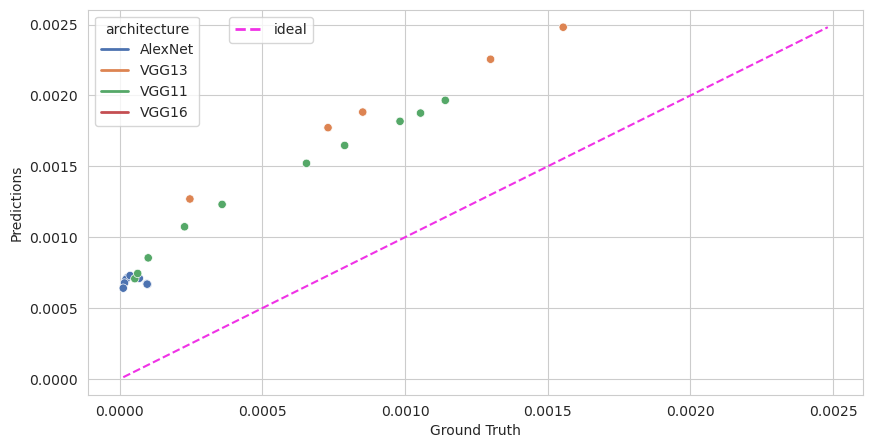

In [22]:
plt.figure(figsize=(10,5))
g = sns.scatterplot(data=full_architecture_preds, x="y", y="y_hat", hue="architecture",palette=["#4C72B0","#DD8452","#55A868","#C44E52"])
min_x = min(min(full_architecture_preds.y), min(full_architecture_preds.y_hat))
max_x = max(max(full_architecture_preds.y), max(full_architecture_preds.y_hat))
g.plot([min_x, max_x], [min_x, max_x], transform=g.transData, linestyle="--", color="#f032e6")
g.set_xlabel("Ground Truth")
g.set_ylabel("Predictions")
custom_lines = [
                plt.Line2D([0], [0], color="#4C72B0", lw=2),
                plt.Line2D([0], [0], color="#DD8452", lw=2),
                plt.Line2D([0], [0], color="#55A868", lw=2),
                plt.Line2D([0], [0], color="#C44E52", lw=2),
]
custom_lines2 = [plt.Line2D([0], [0], color="#f032e6", lw=2, linestyle="--")]
legend2 = g.legend(custom_lines2, ["ideal"], bbox_to_anchor=(0.29, 0.980), loc='upper right', borderaxespad=0.)
g.add_artist(legend2)
plt.legend(custom_lines, ['AlexNet', 'VGG13', 'VGG11', 'VGG16'], title="architecture", loc="best")

# Channel-wise estimates


Conv2d
R2-Score:  -2.30663759725906
Avg-Abs-%-Deviation: 1251.82%


/tmp/ipykernel_62872/2116260682.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])


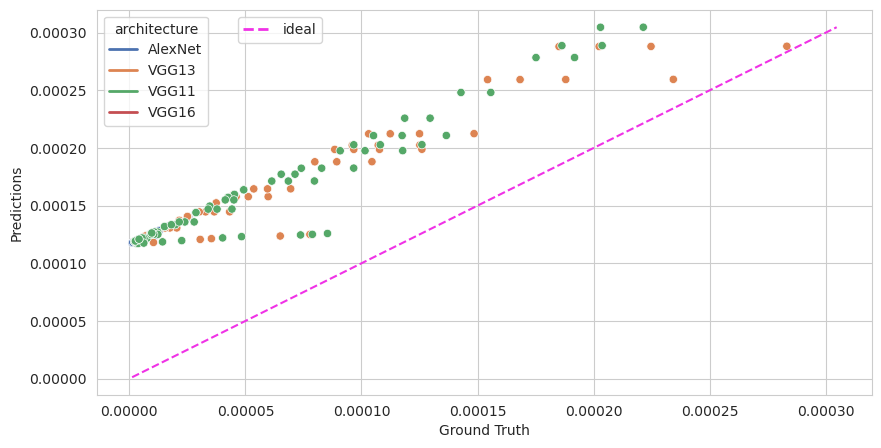

ReLU
R2-Score:  -28.014204641447957
Avg-Abs-%-Deviation: 169513.33%


/tmp/ipykernel_62872/2116260682.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])


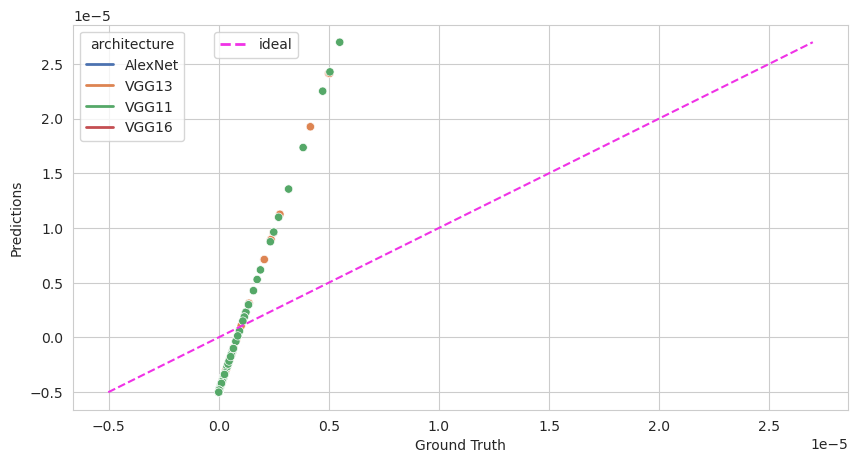

MaxPool2d
R2-Score:  -9.592930804236323
Avg-Abs-%-Deviation: 5071.29%


/tmp/ipykernel_62872/2116260682.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])


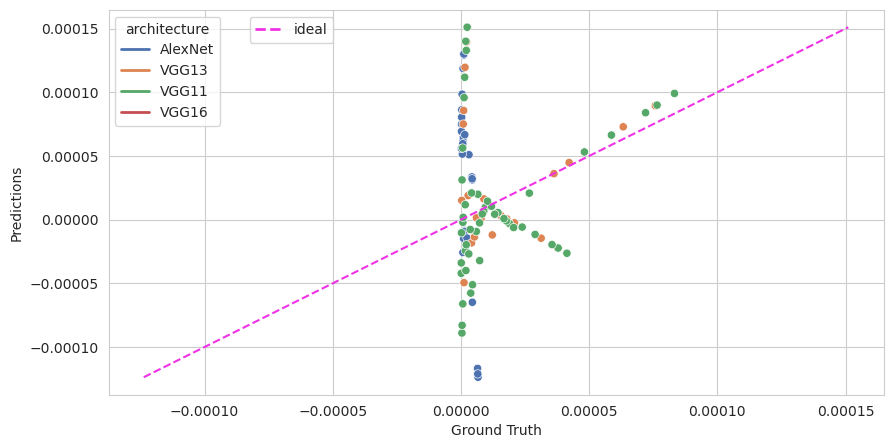

AdaptiveAvgPool2d
R2-Score:  -1.4755923274016136
Avg-Abs-%-Deviation: 100.00%


/tmp/ipykernel_62872/2116260682.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])


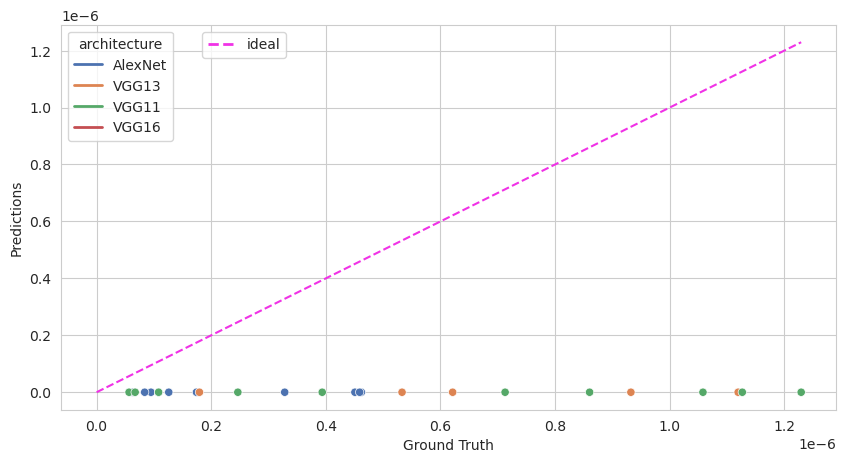

Dropout
R2-Score:  -482.11200674577293
Avg-Abs-%-Deviation: 100.00%


/tmp/ipykernel_62872/2116260682.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])


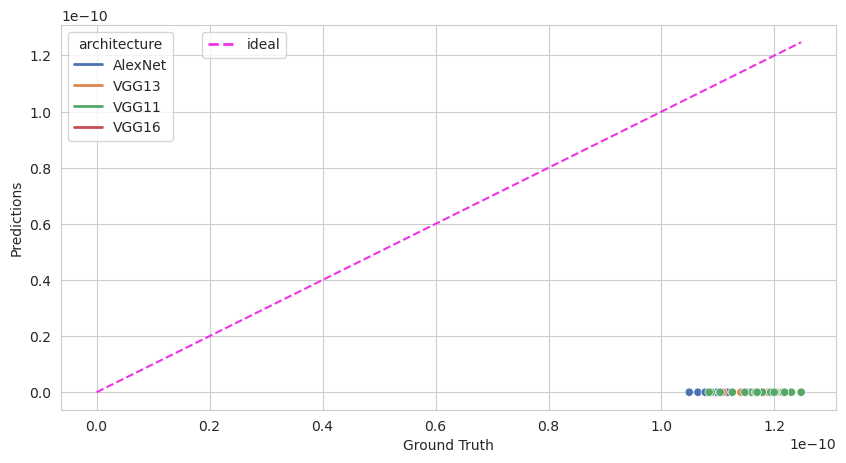

Linear
R2-Score:  0.9677616490039693
Avg-Abs-%-Deviation: 16.37%


/tmp/ipykernel_62872/2116260682.py:8: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])


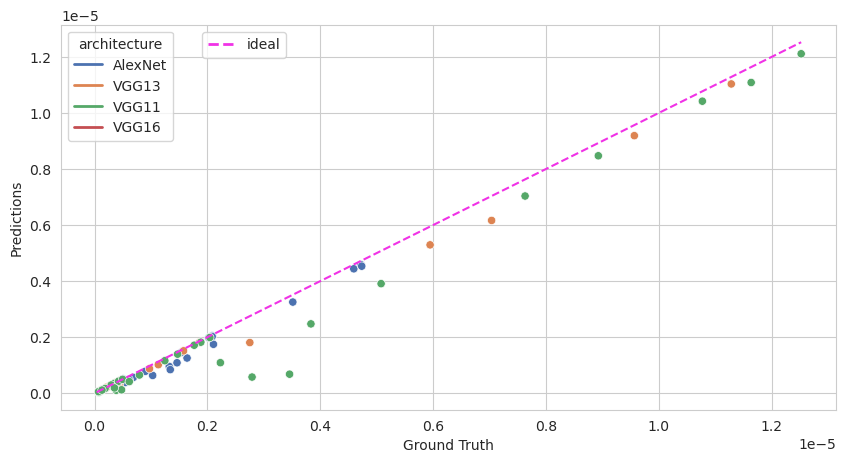

In [23]:
for channel_type in channel_wise_preds.module.unique():
    channel_preds = channel_wise_preds.loc[channel_wise_preds.module == channel_type]
    percent_deviation = abs(channel_preds.y_hat - channel_preds.y) / channel_preds.y
    print(channel_type)
    print(f"R2-Score: ", r2_score(channel_preds.y, channel_preds.y_hat))
    print(f"Avg-Abs-%-Deviation: {percent_deviation.mean():.2%}")
    plt.figure(figsize=(10,5))
    g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])
    min_x = min(min(channel_preds.y), min(channel_preds.y_hat))
    max_x = max(max(channel_preds.y), max(channel_preds.y_hat))
    g.plot([min_x, max_x], [min_x, max_x], transform=g.transData, linestyle="--", color="#f032e6")
    g.set_xlabel("Ground Truth")
    g.set_ylabel("Predictions")
    custom_lines = [
                    plt.Line2D([0], [0], color="#4C72B0", lw=2),
                    plt.Line2D([0], [0], color="#DD8452", lw=2),
                    plt.Line2D([0], [0], color="#55A868", lw=2),
                    plt.Line2D([0], [0], color="#C44E52", lw=2),
    ]
    custom_lines2 = [plt.Line2D([0], [0], color="#f032e6", lw=2, linestyle="--")]
    legend2 = g.legend(custom_lines2, ["ideal"], bbox_to_anchor=(0.29, 0.980), loc='upper right', borderaxespad=0.)
    g.add_artist(legend2)
    plt.legend(custom_lines, ['AlexNet', 'VGG13', 'VGG11', 'VGG16'], title="architecture", loc="best")
    plt.show()